In [26]:
import numpy as np
import scipy as sp
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams, colors
from tqdm import tqdm
import emcee
import corner
import plotly.express as px
import re
import glob
import numpy as np
from PyAstronomy import pyasl

%matplotlib inline
# figure size in inches
rcParams['figure.figsize'] = 12,8
rcParams['axes.formatter.useoffset'] = False

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

### Fitting an apsidal precession model

There are two key papers w.r.t understanding apsidal precession and the transits that result.

Gimenez 1995 presents a formula relating transit times to precession rate.

Ragozzine & Wolf 2009 enumerate the various causes of precession rate and simplified formulas for each. They claim precession rate is linear and all sources sum.

Discrepancy! Raggozzine claim dw/dt is constant, but Gimenez claims dw/dE (sidereal period) is constant.

Let's start off by trying to reproduce some results for WASP-12b from Patra 2017 and Turner 2020.

How much is it precessing, what does it look like when plotted?

$t (E)=T_{0}+P_{a}(1−\frac{1}{2\pi}\frac{dw}{dE})E−eP_{a}cos(w_{0}+\frac{dw}{dE}E)$

The model itself is derived from Gimenez et al 1995. Pa represents the anomalistic period defined as the interval of time between two periastron passages.

In [414]:
# df = pd.read_csv("./data/ORIGINALS/ETD_WASP-12_og.txt", sep="\t", names=["index", "epoch", "transit_time", "error", "data_quality", "observer"])

df = pd.read_csv("./data/turner_2020.csv")
df = df[df.type == "tra"]
# df["transit_time"] = df["transit_time"] - df["transit_time"].quantile(0.5)
# df["epoch"] = df["epoch"] - df["epoch"].quantile(0.5)
df.head()

,type,transit_time,error,epoch,source
0,tra,2.454516e+06,0.00043,-1640,H09
3,tra,2.454836e+06,0.00028,-1346,C13
4,tra,2.454841e+06,0.00062,-1342,Ch11
5,tra,2.455141e+06,0.00042,-1067,C17
6,tra,2.455147e+06,0.00043,-1061,M13


In [477]:
def decay_model(E, T0, P0, dP_dE):
    return T0 + P0*E + 0.5*(dP_dE/1000/60/60/24)*E**2

def precession_model(E, T0, Ps, w0, dw_dE, e):
    w = w0 + (dw_dE*E)
    Pa = Ps/(1-(dw_dE/(2*np.pi)))
    return T0 + (Ps*E) - ((e*Pa/np.pi)*np.cos(w))

def fixed_precession_model(E, T0, w0, dw_dE):
    dw_dE = 0.000963
    w = w0 + (dw_dE*E)
    e = 0.049
    Ps = 1.09
    Pa = Ps / (1-(dw_dE/(2*np.pi)))
    return T0 + (Ps*E) - ((e*Pa/np.pi)*np.cos(w))

def constant_model(E, T_const, P_const):
    return T_const + P_const*E

def fitter(df, model, ml=False, posterior=True):
    def log_likelihood(theta):
        mu = model(df.epoch, *theta)

        diff = df.transit_time - mu
        log_likelihood = -(0.5*len(df)*np.log(2*np.pi)) -(np.sum(np.log(df.error))) -(0.5*diff@((1/np.power(df.error, 2))*diff))

        return log_likelihood

    def log_prior(theta):
        T0, Ps, w0, dw_dE, e = theta
        if Ps <= 0.0:
            return -np.inf  # can't have negative periods
        if e <= 0.0:
            return -np.inf  # can't have negative eccentricity
    
        return 0.0

    def log_probability(theta):
        return log_prior(theta) + log_likelihood(theta)
    
    def neg_log_likelihood(theta):
        return -log_likelihood(theta)
    
    def minimizer(initial_theta, steps=5000):
        if ml:
            res = sp.optimize.minimize(neg_log_likelihood, initial_theta, method="BFGS", tol=1e-6, options={'disp': True, "maxiter": 1e4})
            initial_theta = res.x
        else:
            initial_theta = np.array(initial_theta)

        if not posterior:
            return res.x
        
        pos = initial_theta + 1e-3 * abs(np.random.randn(16, len(initial_theta)))

        nwalkers, ndim = pos.shape
        print("nwalkers", nwalkers, "ndim", ndim)
        sampler = emcee.EnsembleSampler(
            nwalkers, ndim, log_probability
        )
        sampler.run_mcmc(pos, steps, progress=True);
        flat_samples = sampler.get_chain(discard=100, thin=30, flat=True)
        return np.percentile(flat_samples, 50, axis=0)

    return minimizer

In [435]:
T0, P0, dP_dE = fitter(df, model=decay_model, posterior=False)(initial_theta=(0.0, 1.0, 0.0))
T0, P0, dP_dE

         Current function value: -1043.659292
         Iterations: 27
         Function evaluations: 395
         Gradient evaluations: 96


(2456305.455762946, 1.0914200193150323, -0.07195741481096636)

In [437]:
initial = (2456305.45481, 1.091419419, 2.447, 0.000963, 0.00363)
T0, Ps, w0, dw_dE, e = fitter(df, model=precession_model)(initial_theta=initial)
T0, Ps, w0, dw_dE, e

         Current function value: -1044.991120
         Iterations: 0
         Function evaluations: 84
         Gradient evaluations: 12
nwalkers 16 ndim 5


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:12<00:00, 38.99it/s]


(2456305.4547701813,
 1.0914194831862623,
 2.4469535525418746,
 0.000955631986522191,
 0.003803217552234283)

Shape of output array:  (200, 3)
x, y, z for 50th point:  [-0.02207691  0.00800164  0.        ]


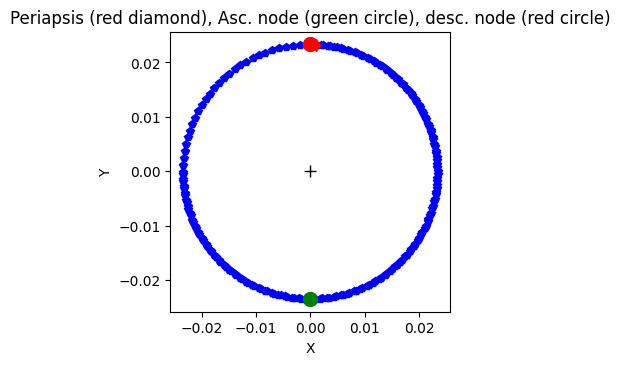

Shape of output array:  (200, 3)
x, y, z for 50th point:  [-0.02208357  0.00798322  0.        ]


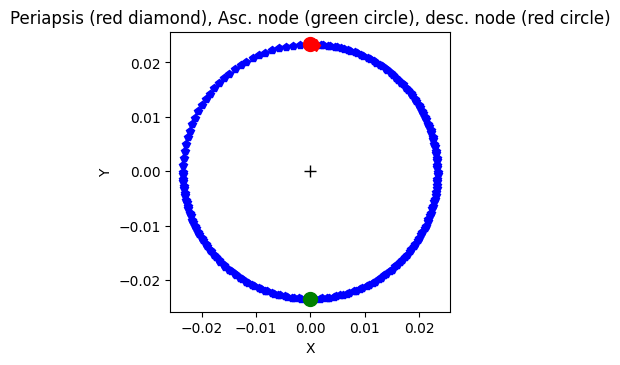

In [438]:
def plot_keplerian(ke):
    # Get a time axis
    t = np.linspace(0, 1.9, 200)

    # Calculate the orbit position at the given points
    # in a Cartesian coordinate system.
    pos = ke.xyzPos(t)
    print("Shape of output array: ", pos.shape)

    # x, y, and z coordinates for 50th time point
    print("x, y, z for 50th point: ", pos[50, ::])

    # Calculate orbit radius as a function of the
    radius = ke.radius(t)

    # Calculate velocity on orbit
    vel = ke.xyzVel(t)

    # Find the nodes of the orbit (Observer at -z)
    ascn, descn = ke.xyzNodes_LOSZ()

    # Plot x and y coordinates of the orbit
    plt.subplot(2, 1, 1)
    plt.title("Periapsis (red diamond), Asc. node (green circle), desc. node (red circle)")
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.plot([0], [0], 'k+', markersize=9)
    plt.plot(pos[::, 1], pos[::, 0], 'bp')
    # Point of periapsis
    plt.plot([pos[0, 1]], [pos[0, 0]], 'rd')
    # Nodes of the orbit
    plt.plot([ascn[1]], [ascn[0]], 'go', markersize=10)
    plt.plot([descn[1]], [descn[0]], 'ro', markersize=10)
    plt.axis('scaled')
    plt.show()
    
plot_keplerian(pyasl.KeplerEllipse(a=0.0234, per=Ps, e=e, Omega=0., i=0, w=w0))
plot_keplerian(pyasl.KeplerEllipse(a=0.0234, per=Ps, e=e, Omega=0., i=0, w=w0+50*dw_dE))

In [439]:
T_const, P_const = fitter(df, model=constant_model, posterior=False)(initial_theta=(0.0, 1.0))
T_const, P_const

         Current function value: -899.665900
         Iterations: 8
         Function evaluations: 75
         Gradient evaluations: 21


(2456305.4555271873, 1.09141952009836)

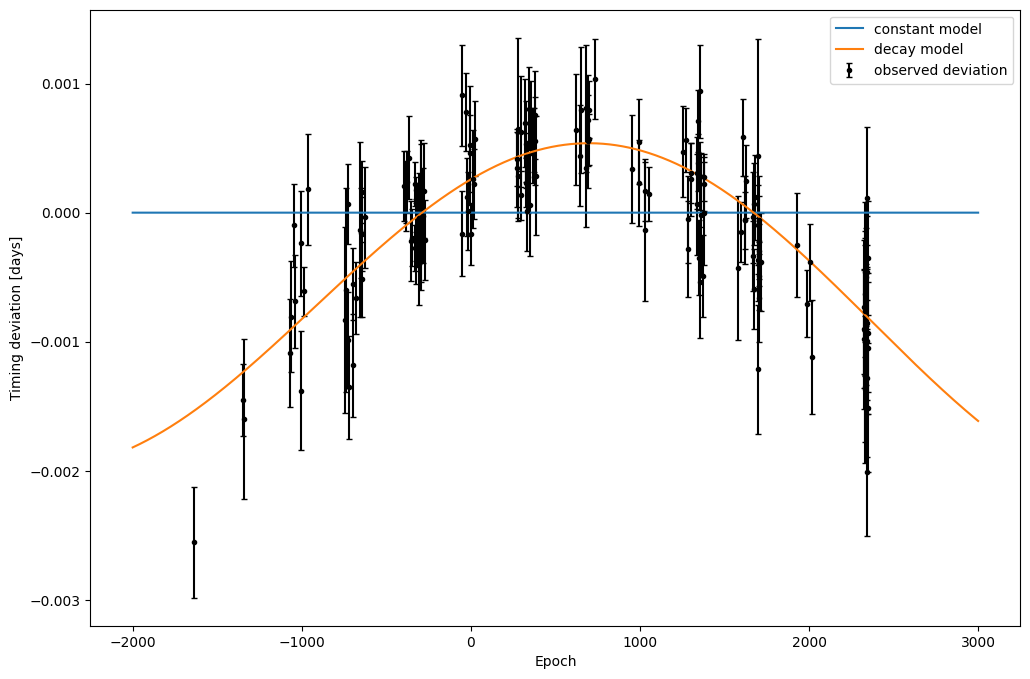

In [440]:
E = np.arange(-2000, 3000, 1)
error = df.error

observed_deviation = df.transit_time - constant_model(df.epoch, T_const, P_const)
plt.errorbar(df.epoch, observed_deviation, yerr=error, fmt=".k", capsize=2, label="observed deviation")

const_y = constant_model(E, T_const, P_const)
precession_y = precession_model(E, T0, Ps, w0, dw_dE, e)
computed_deviation = precession_y - const_y
plt.plot(E, np.full(computed_deviation.shape, 0), label="constant model")
plt.plot(E, computed_deviation, label="decay model")
plt.xlabel("Epoch")
plt.ylabel("Timing deviation [days]")
plt.legend()
plt.show()

We can check the model is fine by plugging Turner's values in and checking if it gives the same curve as he shows:

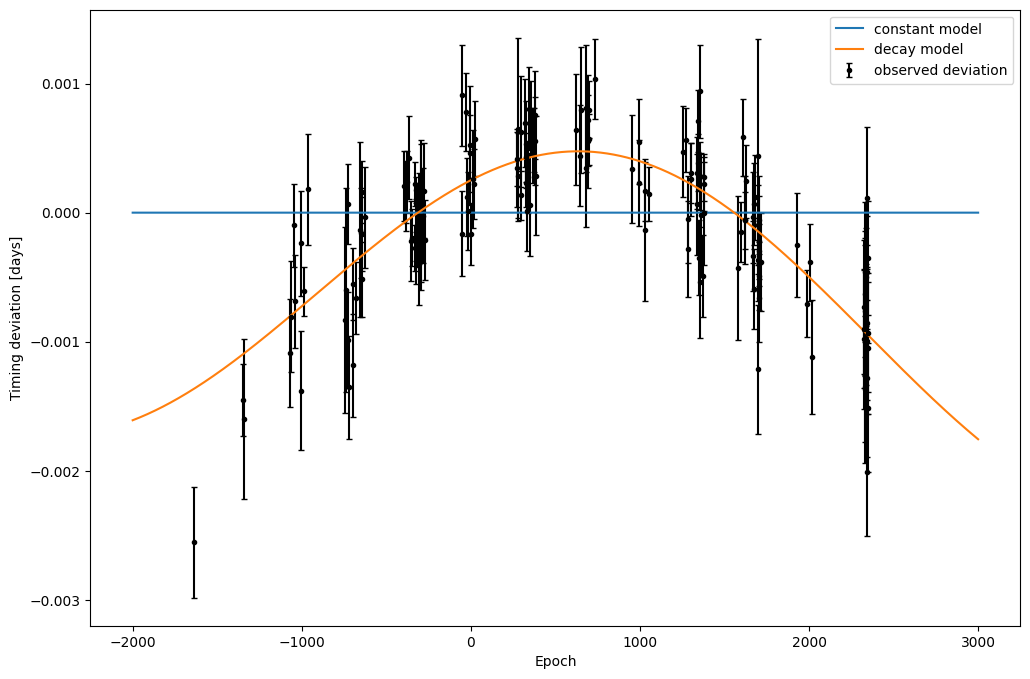

In [441]:
E = np.arange(-2000, 3000, 1)
error = df.error

observed_deviation = df.transit_time - constant_model(df.epoch, T_const, P_const)
plt.errorbar(df.epoch, observed_deviation, yerr=error, fmt=".k", capsize=2, label="observed deviation")

const_y = constant_model(E, T_const, P_const)
precession_y = precession_model(E, T0=2456305.45481, Ps=1.091419419, w0=2.447, dw_dE=0.000963, e=0.00363)
computed_deviation = precession_y - const_y
plt.plot(E, np.full(computed_deviation.shape, 0), label="constant model")
plt.plot(E, computed_deviation, label="decay model")
plt.xlabel("Epoch")
plt.ylabel("Timing deviation [days]")
plt.legend()
plt.show()

Despite my best efforts at replicating the paper faithfully, I cannot reproduce the results. Perhaps they used a particular prior to constrain the model, or initial starting values, or MCMC hyperparameters to get to their fit.

#### Generate fake precession data

Generate fake apsidal precession data and see if my decay model picks it up

<AxesSubplot: xlabel='Epoch', ylabel='Transit time [days]'>

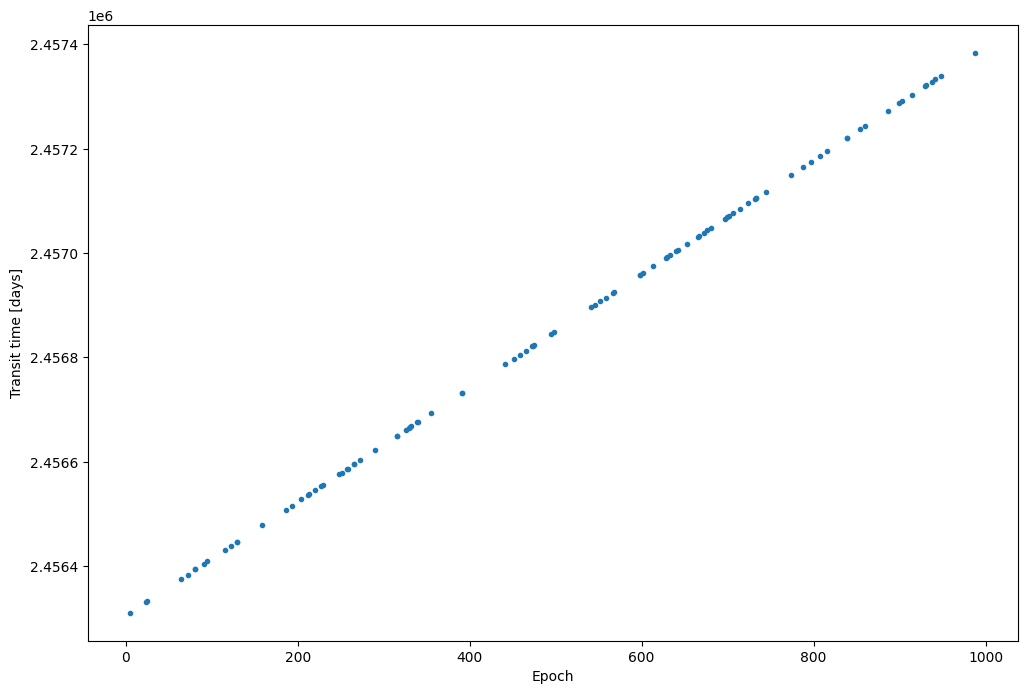

In [461]:
# generate fake observations of a precession model
rng = np.random.default_rng(12345)
E = np.sort(rng.integers(low=0, high=1000, size=100))

T = precession_model(E, T0=2456305.45481, Ps=1.091419419, w0=2.447, dw_dE=0.000963, e=0.00363)  # mean of observations
error = 1 / 24 / 60 / 60

observations = sp.stats.multivariate_normal.rvs(mean=T, cov=sp.stats.Covariance.from_diagonal(np.full(T.shape, error**2)))
observations = pd.Series(data=observations.flatten(), index=E)
observations.plot(style=".", xlabel="Epoch", ylabel="Transit time [days]")

In [458]:
df = pd.DataFrame({"epoch": E, "transit_time": T, "error": error})
df.head()

,epoch,transit_time,error
0,5,2.456311e+06,0.000012
1,24,2.456332e+06,0.000012
2,25,2.456333e+06,0.000012
3,64,2.456375e+06,0.000012
4,72,2.456384e+06,0.000012


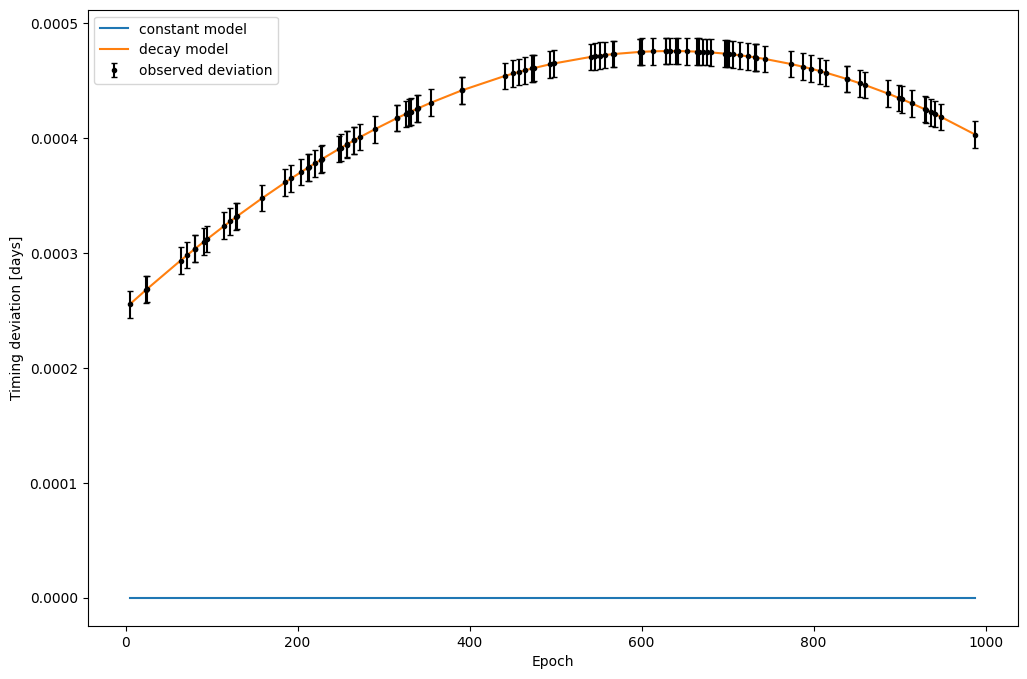

In [467]:
observed_deviation = df.transit_time - constant_model(E, T_const, P_const)
plt.errorbar(df.epoch, observed_deviation, yerr=df.error, fmt=".k", capsize=2, label="observed deviation")

const_y = constant_model(df.epoch, T_const, P_const)
precession_y = precession_model(df.epoch, T0=2456305.45481, Ps=1.091419419, w0=2.447, dw_dE=0.000963, e=0.00363)
computed_deviation = precession_y - const_y
plt.plot(df.epoch, np.full(computed_deviation.shape, 0), label="constant model")
plt.plot(df.epoch, computed_deviation, label="decay model")
plt.xlabel("Epoch")
plt.ylabel("Timing deviation [days]")
plt.legend()
plt.show()

In [478]:
T0, Ps, w0, dw_dE, e = fitter(df, model=precession_model, ml=False, posterior=True)(initial_theta=(0.0, 1.0, 0.0, 0.0, 0.05), steps=50_000)
T0, Ps, w0, dw_dE, e

nwalkers 16 ndim 5


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 50000/50000 [21:43<00:00, 38.37it/s]


(2456304.9048137814,
 1.0937059147800081,
 1186583.2354835412,
 2455870.9416346936,
 10171265.820526002)

MCMC is producing nonsensical results if not initialized close to the true value. It's almost like it's falling into a local minimum and can't get out. I don't really have enough info to replicate the Turner and Patra models.

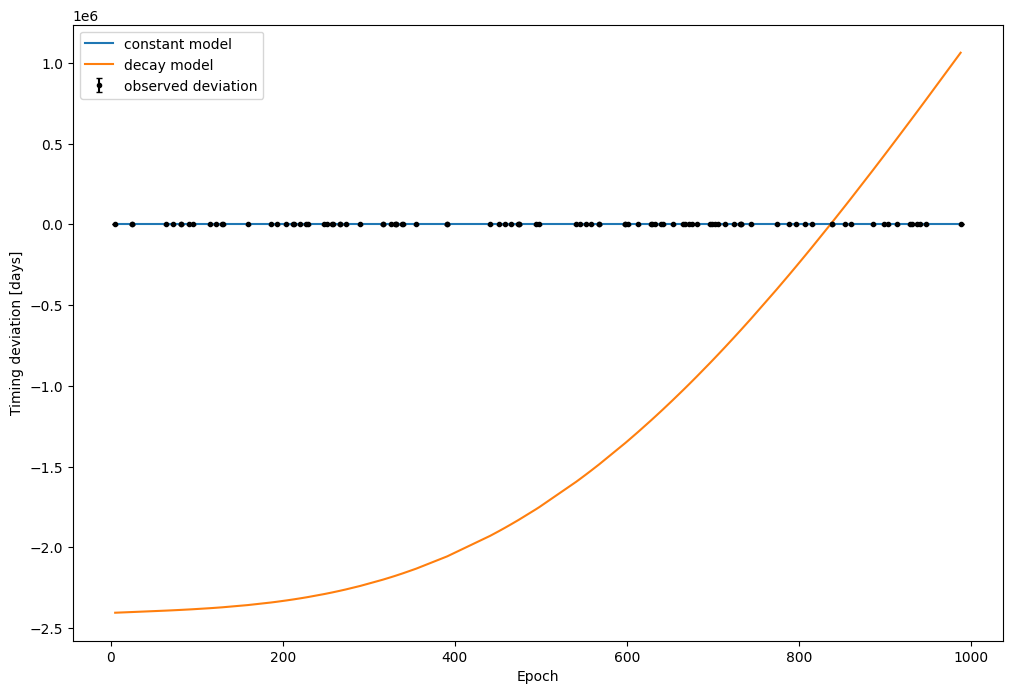

In [476]:
observed_deviation = df.transit_time - constant_model(E, T_const, P_const)
plt.errorbar(df.epoch, observed_deviation, yerr=df.error, fmt=".k", capsize=2, label="observed deviation")

const_y = constant_model(df.epoch, T_const, P_const)
precession_y = precession_model(df.epoch, T0, Ps, w0, dw_dE, e)
computed_deviation = precession_y - const_y
plt.plot(df.epoch, np.full(computed_deviation.shape, 0), label="constant model")
plt.plot(df.epoch, computed_deviation, label="decay model")
plt.xlabel("Epoch")
plt.ylabel("Timing deviation [days]")
plt.legend()
plt.show()

Can a normal decay model pick up on apsidal precession trends?

Depends on the precession rate. Some precession rates look like fast sinusoidal trends which do get missed, some look like slow moving decay trends.

I don't have much of an intuition on what typical precession rates might be, this is something I need to figure out.

TO DO:
- Fourier transforms?

- Then see if a generic chi squared test picks up statistically significant transit timing deviations despite the decay model looking ok.

- Could it be doing both, in which case a joint model would be appropriate
    - Try that out by simply summing the two

- We can’t just sum up the models, that looks to be inconsistent with the literature which says that dw/dt is constant, NOT dw/dE